In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')

import seaborn as sns 

In [2]:
file_path ='C:/Users/82109/Downloads/olist_dataset/'
df_customers = pd.read_csv(file_path + 'olist_customers_dataset.csv')
df_geolocation = pd.read_csv(file_path + 'olist_geolocation_dataset.csv')
df_orders = pd.read_csv(file_path + 'olist_orders_dataset.csv')
df_items = pd.read_csv(file_path + 'olist_order_items_dataset.csv')
df_payments = pd.read_csv(file_path + 'olist_order_payments_dataset.csv')
df_reviews = pd.read_csv(file_path + 'olist_order_reviews_dataset.csv')
df_products = pd.read_csv(file_path + 'olist_products_dataset.csv')
df_sellers = pd.read_csv(file_path + 'olist_sellers_dataset.csv')

### 1. 주문 데이터
#### 현황 분석

- created (주문 생성) ➡️ approved (승인) ➡️ invoiced (송장 발행) ➡️ processing (출고 처리 중) ➡️ shipped (배송 시작) ➡️ delivered (배송 완료)
- 취소된 배송:canceled, unavailable

- 주문 기간: 2016-09-04 ~ 2018-10-17 (약 2년)
- 배송 기간: 중앙값 기준 11일 이며, 전체 주문의 50%는 6~16일 내 배송됨
- 배송 지연: 전반적인 배송은 예정일보다 일찍 도착하지만, 극단적인 조기/지연 배송이 섞여있음
    - 현황: 93.42%가 정상 배송, 6.57%가 배송 지연  

#### 다음 분석 방향
- 배송의 지연이 고객 경험(리뷰, 재구매)에 미치는 영향 분석 필요

In [40]:
#결측치 확인
print(df_orders.info())
#중복값 확인
print(df_orders['order_id'].nunique() == len(df_orders))
print(df_orders['customer_id'].nunique() == len(df_orders))
# 분포 확인
print(df_orders.order_status.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   delivery_efficiency            96476 non-null  float64       
 9   is_delayed                     99441 non-null  int32         
dtypes: datetime64[ns](5), float64(1), int32(1), object(3)
memory usage: 7.2+ MB
None
T

In [41]:
#날짜형 변환
df_orders['order_purchase_timestamp']= pd.to_datetime(df_orders['order_purchase_timestamp'])
df_orders['order_approved_at']= pd.to_datetime(df_orders['order_approved_at'])
df_orders['order_delivered_carrier_date']= pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_orders['order_delivered_customer_date']= pd.to_datetime(df_orders['order_delivered_customer_date'])
df_orders['order_estimated_delivery_date']= pd.to_datetime(df_orders['order_estimated_delivery_date'])
#날짜 범위 확인
print(df_orders['order_purchase_timestamp'].min()," ~ "
, df_orders['order_purchase_timestamp'].max())

2016-09-04 21:15:19  ~  2018-10-17 17:30:18


In [43]:
print('-----배송 지연 여부, 배송 예정일 대비 도착일 열 생성-----')

# 시간을 자정으로 통일한 후 차이 계산
df_orders['delivery_efficiency'] = (
    df_orders['order_estimated_delivery_date'].dt.normalize() - 
    df_orders['order_delivered_customer_date'].dt.normalize()
).dt.days

# 지연 여부 판단 (이제 날짜가 같으면 0, 예정이 빠르면 음수)
df_orders['is_delayed'] = (df_orders['delivery_efficiency'] < 0).astype(int)

#분포 꼬리 확인
print(df_orders['delivery_efficiency'].describe())
print(df_orders['delivery_efficiency'].quantile([0.01, 0.99]))

#배송 지연 분포
print(df_orders['is_delayed'].value_counts())
print(df_orders['is_delayed'].value_counts(normalize=True))

-----배송 지연 여부, 배송 예정일 대비 도착일 열 생성-----
count    96476.000000
mean        11.876881
std         10.183854
min       -188.000000
25%          7.000000
50%         12.000000
75%         17.000000
max        147.000000
Name: delivery_efficiency, dtype: float64
0.01   -18.0
0.99    36.0
Name: delivery_efficiency, dtype: float64
0    92906
1     6535
Name: is_delayed, dtype: int64
0    0.934283
1    0.065717
Name: is_delayed, dtype: float64


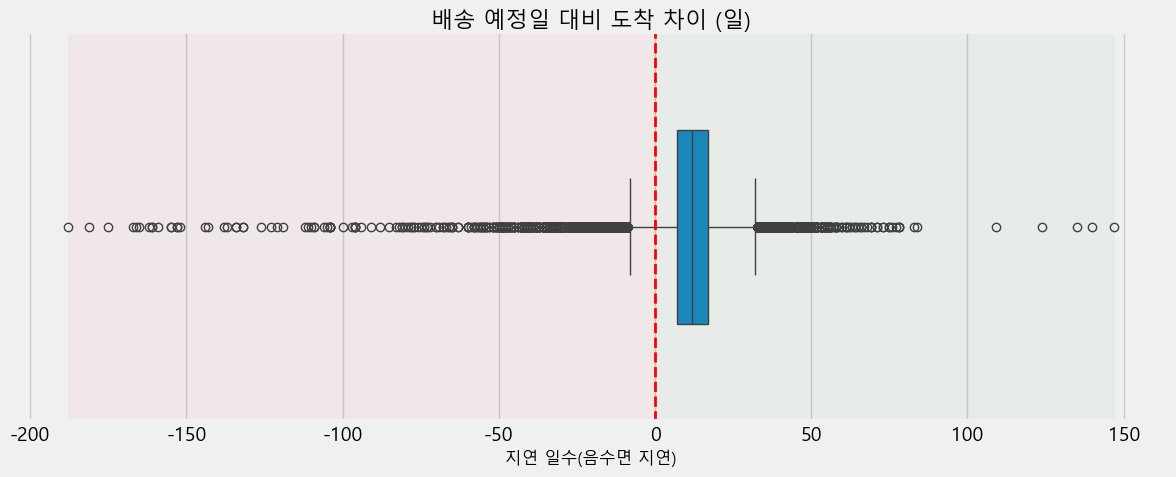

In [7]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df_orders['delivery_efficiency'], width=0.5)
plt.axvline(x=0, color='red', linestyle='--',linewidth=2)
plt.axvspan(df_orders['delivery_efficiency'].min(), 0, color='red', alpha=0.03)
plt.axvspan(0, df_orders['delivery_efficiency'].max(), color='green', alpha=0.03)

plt.title('배송 예정일 대비 도착 차이 (일)', fontsize=16,pad =2)
plt.xlabel('지연 일수(음수면 지연)', fontsize=12)
plt.tight_layout()
plt.show()

In [47]:
#지연일수 통계값
df_orders.loc[df_orders['delivery_efficiency'] < 0, 'delivery_efficiency'].describe()

count    6535.000000
mean      -10.620352
std        14.643844
min      -188.000000
25%       -13.000000
50%        -7.000000
75%        -3.000000
max        -1.000000
Name: delivery_efficiency, dtype: float64

### 2. 결제 데이터
#### 현황 분석
- **1:N관계**, payment_sequential에 따라 데이터가 중복됨
- 결제 수단 중 신용카드가 74% 사용되고, 가장 고액의 금액이 결제됨(금액별 voleto > debit_card > voucher)
- 결제 금액 분포는 평균(154)과 중앙값(100) 차이가 크다(분포가 한쪽으로 치우쳐있다)
- **특이사항**: 결제 금액이 0원인 건은 'not_defined' 결제 수단으로 분류됨을 확인, 이는 오류가 아닌 특정 프로모션 케이스로 판단하여 분석 대상에 포함함

In [62]:
#결측치, 분포 파악
print('-----결제 데이터 결측치 및 분포 파악-----\n')
print(df_payments.info())
print(df_payments['order_id'].nunique() == len(df_payments))
print(df_payments.payment_type.value_counts())
print(df_payments.payment_type.value_counts(normalize=True)*100)
#중복 데이터 확인 
sample_id = df_payments['order_id'].value_counts().idxmax()
df_payments[df_payments['order_id'] == sample_id].sort_values(by='payment_sequential')

-----결제 데이터 결측치 및 분포 파악-----

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
None
False
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64
credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: payment_type, dtype: float64


,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66
29648,fa65dad1b0e818e3ccc5cb0e39231352,6,voucher,1,5.02
82593,fa65dad1b0e818e3ccc5cb0e39231352,7,voucher,1,0.32
68853,fa65dad1b0e818e3ccc5cb0e39231352,8,voucher,1,26.02
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


In [10]:
#결제금액 통계 및 분포
print('-----결제금액 통계 및 분포-----')
print(df_payments.payment_value.describe())

df_payments['payment_value'].quantile([0.01, 0.90,0.95, 0.99])

-----결제금액 통계 및 분포-----
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64


0.01       6.6900
0.90     297.2700
0.95     437.6350
0.99    1039.9165
Name: payment_value, dtype: float64

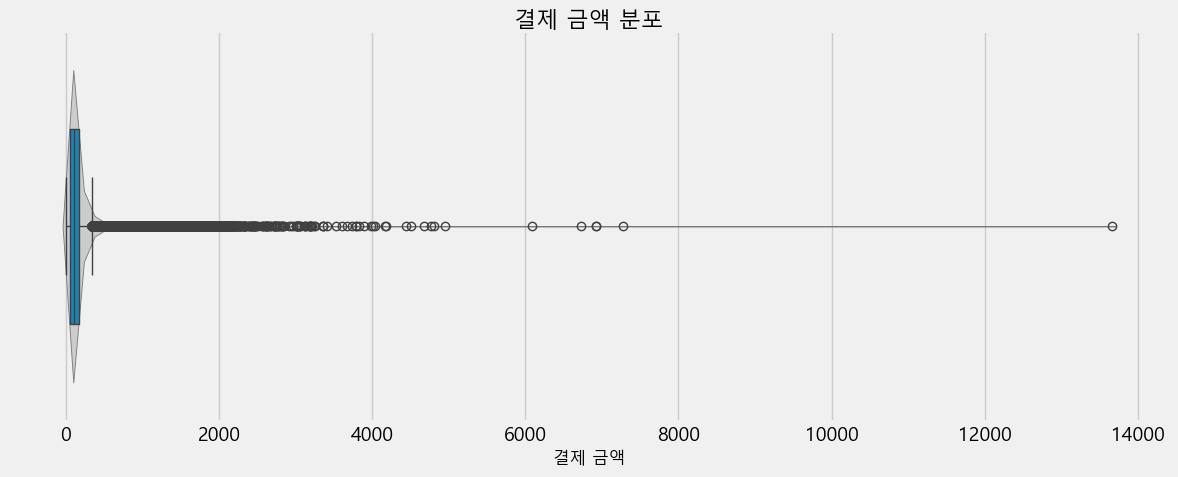

In [11]:
plt.figure(figsize=(12, 5))
sns.violinplot(x=df_payments['payment_value'], inner=None, color=".8")
sns.boxplot(x=df_payments['payment_value'], width = 0.5)
plt.title('결제 금액 분포', fontsize=16, pad=2)
plt.xlabel('결제 금액', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
#결제 수단별 결제 금액 비교
##신용카드가 가장 높은 결제 금액을 가짐
print('--결제수단별 결제 금액 평균 값--')
print(df_payments.groupby('payment_type')['payment_value'].mean().sort_values(ascending=False))
print('--결제수단별 결제 금액 중앙 값--')
print(df_payments.groupby('payment_type')['payment_value'].median().sort_values(ascending=False))

--결제수단별 결제 금액 평균 값--
payment_type
credit_card    163.319021
boleto         145.034435
debit_card     142.570170
voucher         65.703354
not_defined      0.000000
Name: payment_value, dtype: float64
--결제수단별 결제 금액 중앙 값--
payment_type
credit_card    106.87
boleto          93.89
debit_card      89.30
voucher         39.28
not_defined      0.00
Name: payment_value, dtype: float64


C:\Users\82109\AppData\Local\Temp\ipykernel_15388\3687936249.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_per_type.values, y=value_per_type.index, palette='Set2')


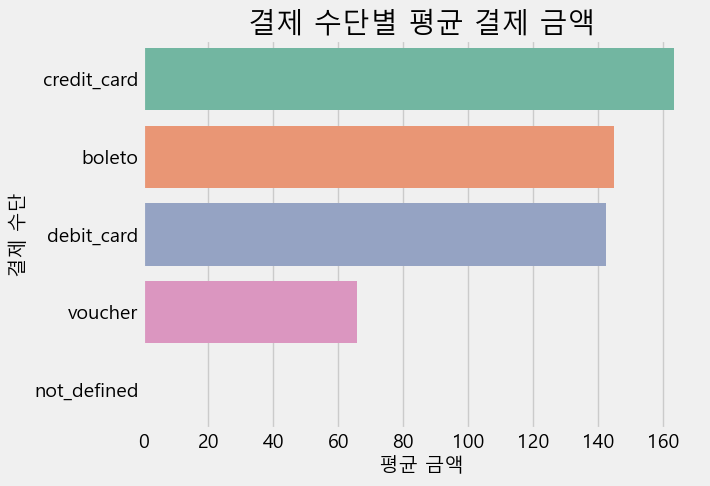

In [63]:
value_per_type = df_payments.groupby('payment_type')['payment_value'].mean().sort_values(ascending=False)
sns.barplot(x=value_per_type.values, y=value_per_type.index, palette='Set2')
plt.title('결제 수단별 평균 결제 금액')
plt.xlabel('평균 금액')
plt.ylabel('결제 수단')
plt.show()

### 3. 고객 데이터
#### 현황 분석
- **1:N관계** customer_unique_id는 고객 단위, customer_id는 주문 단위로 주문에 따라 같은 고객마다 다른 customer_id가 생성 
 
- 1회 구매자가 약 96.95%로 대부분을 차지하고, 재구매율은 3.04%로 극히 낮음
- 주:상위 10개의 state에서 90%의 고객이 거주함
- 도시:sao paulo 등 소수 대도시에 고객이 집중됨 (sao paulo:15.6%, 상위 5개 도시:약 29%, SP주: 42%)

#### 다음 분석 방향
- 지역별 배송 기간 차이와 배송 지연 현황 분석 예정

In [15]:
#데이터 분포 및 고유값 확인 
print(df_customers.info())
print(df_customers['customer_id'].nunique() == len(df_customers))
print(df_customers['customer_unique_id'].nunique() == len(df_customers))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
True
False


In [64]:
#중복 데이터 확인 
sample_id = df_customers['customer_unique_id'].value_counts().idxmax()
df_customers[df_customers['customer_unique_id'] == sample_id]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
14186,1bd3585471932167ab72a84955ebefea,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
15321,a8fabc805e9a10a3c93ae5bff642b86b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
16654,897b7f72042714efaa64ac306ba0cafc,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
36122,b2b13de0770e06de50080fea77c459e6,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
38073,42dbc1ad9d560637c9c4c1533746f86d,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
40141,dfb941d6f7b02f57a44c3b7c3fefb44b,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
48614,65f9db9dd07a4e79b625effa4c868fcb,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
52574,1c62b48fb34ee043310dcb233caabd2e,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
58707,a682769c4bc10fc6ef2101337a6c83c9,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP
67996,6289b75219d757a56c0cce8d9e427900,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP


In [17]:
#지역별 분포
print('고객 거주하는 도시의 수: ', df_customers.customer_city.nunique())
print('고객 거주하는 주의 수: ', df_customers.customer_state.nunique())
print(df_customers['customer_city'].value_counts(normalize=True).head())
print(df_customers['customer_state'].value_counts(normalize=True).head())

고객 거주하는 도시의 수:  4119
고객 거주하는 주의 수:  27
sao paulo         0.156274
rio de janeiro    0.069207
belo horizonte    0.027886
brasilia          0.021430
curitiba          0.015296
Name: customer_city, dtype: float64
SP    0.419807
RJ    0.129242
MG    0.117004
RS    0.054967
PR    0.050734
Name: customer_state, dtype: float64


In [65]:
top_states = df_customers['customer_state'].value_counts().head(10)
print(top_states)

buttom_states =  df_customers['customer_state'].value_counts().tail(10).sort_values()
print(buttom_states)

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
Name: customer_state, dtype: int64
RR     46
AP     68
AC     81
AM    148
RO    253
TO    280
SE    350
AL    413
RN    485
PI    495
Name: customer_state, dtype: int64


In [66]:
#상위 10개의 state에서 90%의 고객이 거주함
state_ratio = df_customers['customer_state'].value_counts(normalize=True)
print(state_ratio.head())
print(state_ratio.cumsum())

SP    0.419807
RJ    0.129242
MG    0.117004
RS    0.054967
PR    0.050734
Name: customer_state, dtype: float64
SP    0.419807
RJ    0.549049
MG    0.666053
RS    0.721021
PR    0.771754
SC    0.808329
BA    0.842319
DF    0.863839
ES    0.884283
GO    0.904597
PE    0.921210
CE    0.934645
PA    0.944449
MT    0.953570
MA    0.961082
MS    0.968273
PB    0.973663
PI    0.978641
RN    0.983518
AL    0.987671
SE    0.991191
TO    0.994006
RO    0.996551
AM    0.998039
AC    0.998854
AP    0.999537
RR    1.000000
Name: customer_state, dtype: float64


In [67]:
city_ratio = df_customers['customer_city'].value_counts(normalize=True)
print(city_ratio.head())
print(city_ratio.cumsum().head(20))

sao paulo         0.156274
rio de janeiro    0.069207
belo horizonte    0.027886
brasilia          0.021430
curitiba          0.015296
Name: customer_city, dtype: float64
sao paulo                0.156274
rio de janeiro           0.225480
belo horizonte           0.253366
brasilia                 0.274796
curitiba                 0.290092
campinas                 0.304613
porto alegre             0.318480
salvador                 0.331000
guarulhos                0.342957
sao bernardo do campo    0.352390
niteroi                  0.360928
santo andre              0.368942
osasco                   0.376444
santos                   0.383614
goiania                  0.390573
sao jose dos campos      0.397522
fortaleza                0.404099
sorocaba                 0.410464
recife                   0.416629
florianopolis            0.422361
Name: customer_city, dtype: float64


C:\Users\82109\AppData\Local\Temp\ipykernel_15388\456106835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x= top_states.index, y=top_states.values, palette ='Set3')


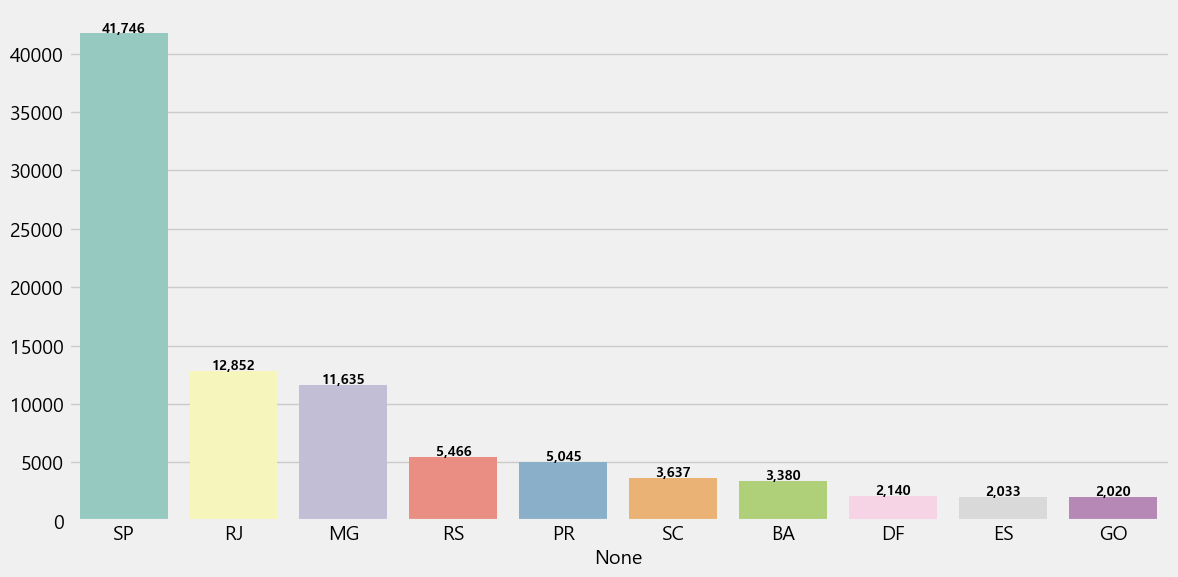

In [78]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x= top_states.index, y=top_states.values, palette ='Set3')
for i,v in enumerate(top_states.values):
    ax.text(i, v+150, f'{v:,}', ha='center', fontweight='bold', fontsize=10)

sns.despine()
plt.tight_layout()
plt.show()

In [81]:
#전체 재구매율 
df_orders_customers = pd.merge(df_orders,df_customers[['customer_id','customer_unique_id']], on='customer_id')
df_clean = df_orders_customers[~df_orders_customers['order_status'].isin(['canceled', 'unavailable'])].copy()

user_order_counts = df_clean.groupby('customer_unique_id')['order_id'].nunique().reset_index()
user_order_counts.columns = ['customer_unique_id', 'order_count']

#재구매여부 판별
user_order_counts['is_repurchase'] = (user_order_counts['order_count'] > 1).astype(int)

#전체 재구매율 계산
total_users = len(user_order_counts)
repurchase_users = user_order_counts['is_repurchase'].sum()
total_repurchase_rate = (repurchase_users / total_users) * 100

print(f"전체 재구매율: {total_repurchase_rate:.2f}")

전체 재구매율: 3.04


In [21]:
#구매 횟수 분포
print(user_order_counts['order_count'].value_counts())
print(user_order_counts['order_count'].value_counts(normalize=True))

1     92102
2      2652
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: order_count, dtype: int64
1     0.969597
2     0.027919
3     0.001979
4     0.000305
5     0.000095
6     0.000053
7     0.000032
9     0.000011
16    0.000011
Name: order_count, dtype: float64


### 4 주문 아이템 데이터
#### 현황 분석

- **1:N관계** 주문한 아이템의 갯수에 따라 상세 정보가 나타남

- 상품 가격 분포를 보면, 대부분의 상품은 저~중가에 몰려있음
    - 평균 가격 약 120.65헤알, 중앙값은 약 74.99헤알
- 배송비 분포도 긴 우측 꼬리 가짐
    - 평균은 약 19.99헤알, 중앙값은 16.26헤알
    
- 전체의 약 97% 고객이 한 주문 당 3개 이하로 구매 (전체의 87%의 고객이 1개 구매)
- 셀러 처리 지연은 약 9%로 10413건 존재

#### 앞으로 분석 방향

- 셀러의 처리 지연이 전체 배송 지연에 미치는 영향을 분석할 필요가 있음

In [22]:
print(df_items.info())
print(df_items['order_item_id'].value_counts())
print(df_items['order_item_id'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB
None
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: order_item_id, dtype: int64
1     0.875863
2     0.087022
3     0.020302
4     0.008566
5     0.004083
6  

In [23]:
#날짜형 변환
df_items['shipping_limit_date']= pd.to_datetime(df_items['shipping_limit_date'])

In [24]:
#취소값 제외
df_orders_f = df_orders[~df_orders['order_status'].isin(['canceled', 'unavailable'])].copy()

#병합
df_orders_items = pd.merge(df_orders_f,df_items[['order_id', 'shipping_limit_date']], on='order_id', how='left')

#지연여부
df_orders_items['late_process'] = (df_orders_items['order_delivered_carrier_date'] > df_orders_items['shipping_limit_date']).map({
    True: '지연', False: '정상'
})
print(df_orders_items['late_process'].value_counts())
print(df_orders_items['late_process'].value_counts(normalize=True))

정상    101696
지연     10413
Name: late_process, dtype: int64
정상    0.907117
지연    0.092883
Name: late_process, dtype: float64


In [83]:
# 1:N 관계 
df_items['order_id'].nunique() == len(df_items)
smple_id = df_items['order_id'].value_counts().idxmax()
df_items[df_items['order_id']==smple_id]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [82]:
#보통 한 주문에 몇개 주문하지? 
df_items['order_item_id'].value_counts(normalize=True).cumsum()

1     0.875863
2     0.962885
3     0.983187
4     0.991753
5     0.995837
6     0.998109
7     0.998624
8     0.998944
9     0.999192
10    0.999414
11    0.999565
12    0.999680
13    0.999751
14    0.999814
15    0.999858
16    0.999885
17    0.999911
18    0.999938
19    0.999964
20    0.999991
21    1.000000
Name: order_item_id, dtype: float64

In [25]:
#가격과 배송비 분포
print(df_items['price'].describe())
print(df_items['freight_value'].describe())

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64
count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64


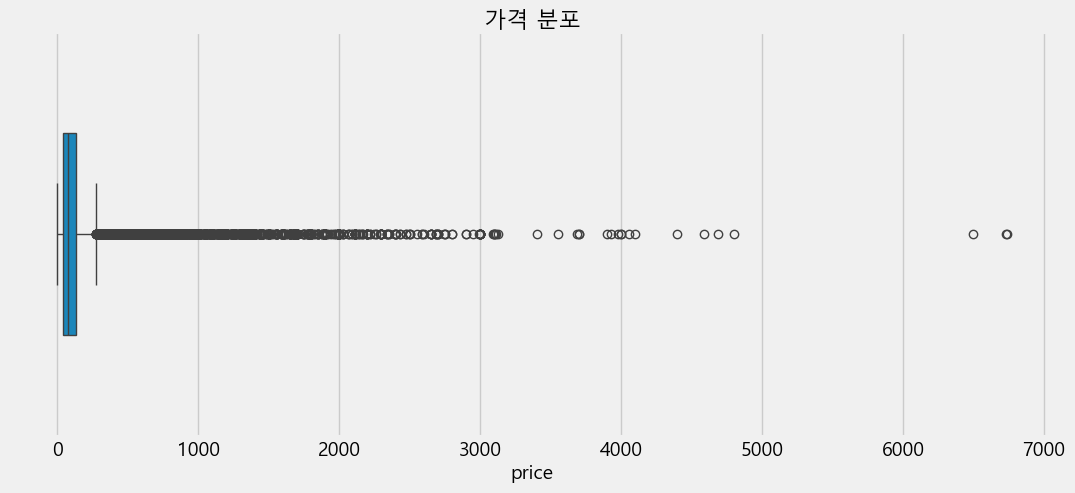

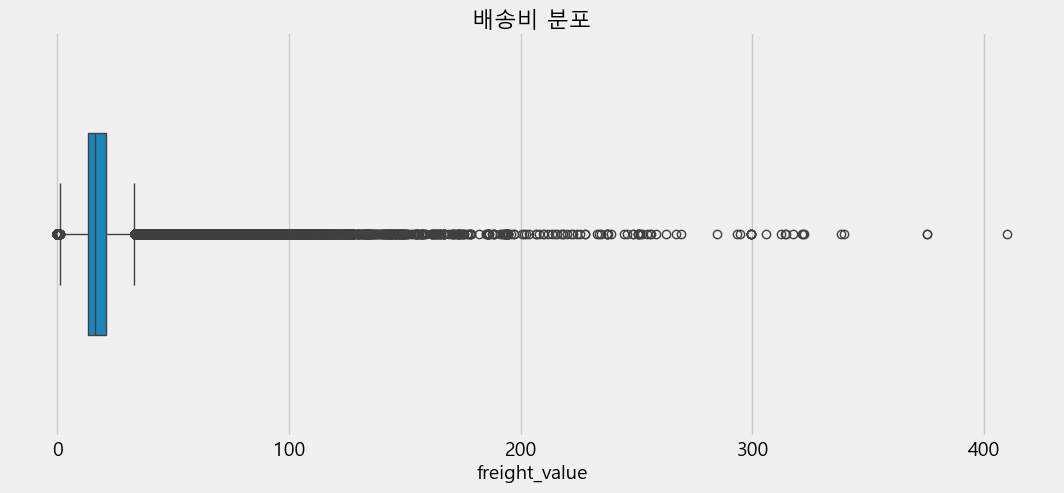

In [85]:
plt.figure(figsize=(12,5))
sns.boxplot(x='price', data=df_items, width =0.5)
plt.title('가격 분포',fontsize=16,pad=2)
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='freight_value', data=df_items, width =0.5)
plt.title('배송비 분포',fontsize=16,pad=2)
plt.show()

### 5. 리뷰 데이터
#### 현황 분석
 
- 주문 아이디와 리뷰 아이디는 **다대다 관계(N:M)**
    - **1. 하나의 주문 ID - 여러개의 리뷰 ID**
        - 점수 변동 주문: 202건
        - 내용 변동 주문: 126건
        - 날짜 변동 주문: 547건

    - **2. 여러 주문 ID - 하나의 리뷰 ID** 
- 리뷰 점수는 전반적으로 높으나, 불만족 고객(1점)이 중간 만족(2~3점) 고객보다 더 많이 존재하는 양극화된 분포를 보임
- **대부분의 고객이 리뷰 스코어를 제출함**
    - 리뷰 쓴 비율: 98.96% / 리뷰 안쓴 사람 수: 1031

#### 다음 분석 방향
- 배송의 지연 상태가 리뷰점수에 어떤 영향을 주는지 분석이 필요함

In [50]:
#분포 확인
print(df_reviews.info())

#리뷰 아이디 중복 확인
print(f"리뷰 아이디가 고유한가요? {df_reviews['review_id'].nunique() == len(df_reviews)}")
print(f"주문 아이디가 고유한가요? {df_reviews['order_id'].nunique() == len(df_reviews)}")

review_per_order = df_reviews.groupby('order_id')['review_id'].nunique()
print(review_per_order.value_counts())

order_per_review = df_reviews.groupby('review_id')['order_id'].nunique()
print(order_per_review.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
리뷰 아이디가 고유한가요? False
주문 아이디가 고유한가요? False
1    98126
2      543
3        4
Name: review_id, dtype: int64
1    97621
2      764
3       25
Name: order_id, dtype: int64


In [53]:
# 한 주문 당 여러개의 review_id를 가질 때 
id_num_check1 = df_reviews.groupby('order_id')['review_id'].nunique()
multi_review_order = id_num_check1[id_num_check1>1].index
df_multi_review = df_reviews[df_reviews['order_id'].isin(multi_review_order)].sort_values(by=['order_id','review_answer_timestamp'])
df_multi_review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06


In [54]:
## 한 주문 당 여러개의 review_id를 가질 때 변화 확인
df_review_change = df_multi_review.groupby('order_id')[['review_score','review_answer_timestamp','review_comment_message']].nunique().reset_index()
#점수가 변한 경우 
score_changed = len(df_review_change[df_review_change['review_score'] > 1])
date_changed = len(df_review_change[df_review_change['review_answer_timestamp'] > 1])
comment_changed = len(df_review_change[df_review_change['review_comment_message'] > 1])
print(f"1. 점수 변동 주문: {score_changed}건")
print(f"2. 내용 변동 주문: {comment_changed}건")
print(f"3. 날짜 변동 주문: {date_changed}건")

1. 점수 변동 주문: 202건
2. 내용 변동 주문: 126건
3. 날짜 변동 주문: 547건


In [56]:
#하나의 리뷰에 여러개 주문 아이디를 가질 때

id_num_check2 = df_reviews.groupby('review_id')['order_id'].nunique()
multi_order = id_num_check2.loc[id_num_check2>1].index
df_multi_order = df_reviews[df_reviews['review_id'].isin(multi_order)].sort_values(by='review_id')
df_multi_order.head(20)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21 00:00:00,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21 00:00:00,2017-09-26 03:27:47
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07 00:00:00,2018-03-08 03:00:53
57280,0174caf0ee5964646040cd94e15ac95e,74db91e33b4e1fd865356c89a61abf1f,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07 00:00:00,2018-03-08 03:00:53
54832,017808d29fd1f942d97e50184dfb4c13,8daaa9e99d60fbba579cc1c3e3bfae01,5,NaN,NaN,2018-03-02 00:00:00,2018-03-05 01:43:30
99167,017808d29fd1f942d97e50184dfb4c13,b1461c8882153b5fe68307c46a506e39,5,NaN,NaN,2018-03-02 00:00:00,2018-03-05 01:43:30
20621,0254bd905dc677a6078990aad3331a36,5bf226cf882c5bf4247f89a97c86f273,1,NaN,O pedido consta de 2 produtos e até agora rece...,2017-09-09 00:00:00,2017-09-13 09:52:44
96080,0254bd905dc677a6078990aad3331a36,331b367bdd766f3d1cf518777317b5d9,1,NaN,O pedido consta de 2 produtos e até agora rece...,2017-09-09 00:00:00,2017-09-13 09:52:44


In [59]:
df_orders_reviews= df_orders.merge(df_reviews, on='order_id', how='left')
not_review = (df_orders_reviews['order_id'].nunique() - df_orders_reviews['review_id'].nunique())
review_pct = df_orders_reviews['review_id'].nunique() / df_orders_reviews['order_id'].nunique()
print(f'리뷰 쓴 비율: {round(review_pct,4)}')
print(f'리뷰 안쓴 사람 수: {not_review}')

리뷰 쓴 비율: 0.9896
리뷰 안쓴 사람 수: 1031


In [60]:
#리뷰 스코어 분포
df_reviews_f = df_reviews.sort_values('review_answer_timestamp').drop_duplicates('order_id', keep='last')

print(df_reviews_f['review_score'].value_counts())
print(df_reviews_f['review_score'].value_counts(normalize=True))

5    57008
4    19038
1    11363
3     8133
2     3131
Name: review_score, dtype: int64
5    0.577747
4    0.192940
1    0.115158
3    0.082424
2    0.031731
Name: review_score, dtype: float64


In [29]:
# 하나의 주문 ID - 여러개의 리뷰 ID
# 점수 그대로: 보강하거나, 리뷰를 더 구체화 / 점수 변화: 실제 사용 후 경험 변화

review_per_order = df_reviews.groupby('order_id')['review_id'].nunique()
multi_review_order = review_per_order[review_per_order > 1].index
df_multi_reviews = df_reviews[df_reviews['order_id'].isin(multi_review_order)].sort_values(['order_id', 'review_answer_timestamp'])

review_diff = df_multi_reviews.groupby('order_id')['review_score'].agg(['first', 'last'])

conditions = [
review_diff['last'] > review_diff['first'],
review_diff['last'] < review_diff['first']
]

choices = ['Increased', 'Decreased']
review_diff['change_type'] = np.select(conditions, choices, default='No Change')
review_diff['change_type'].value_counts()

No Change    346
Decreased    113
Increased     88
Name: change_type, dtype: int64

C:\Users\82109\AppData\Local\Temp\ipykernel_15388\39141788.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=review_diff, x='change_type', palette = 'Set2')


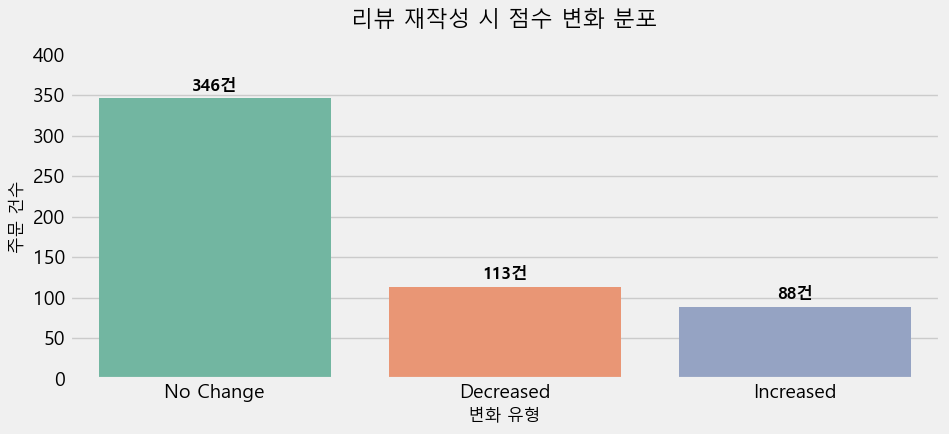

In [30]:
plt.figure(figsize=(10,4))
ax = sns.countplot(data=review_diff, x='change_type', palette = 'Set2')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}건', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')


plt.title('리뷰 재작성 시 점수 변화 분포',fontsize=16, pad = 20)
plt.xlabel('변화 유형', fontsize= 12)
plt.ylabel('주문 건수', fontsize= 12)
plt.ylim(0,400)
plt.show()

### 6. 제품 데이터
#### 현황 분석
- 총 73개의 카테고리, 32951개의 제품이 있음

In [31]:
#데이터 분포
df_products.info()
#고유값 확인
df_products[df_products['product_id'].duplicated()]
#카테고리 갯수
print(f"카테고리 갯수: {df_products['product_category_name'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB
카테고리 갯수: 73


In [32]:
#카테고리별 상품 분포
print(df_products['product_category_name'].value_counts().head(10))

cama_mesa_banho           3029
esporte_lazer             2867
moveis_decoracao          2657
beleza_saude              2444
utilidades_domesticas     2335
automotivo                1900
informatica_acessorios    1639
brinquedos                1411
relogios_presentes        1329
telefonia                 1134
Name: product_category_name, dtype: int64


In [33]:
#카테고리별 매출 순위
df_items_products = df_items.merge(
                    df_products[['product_id', 'product_category_name']], 
                    on = 'product_id',
                    how='left')

df_items_products['revenue']= df_items_products['price'] + df_items_products['freight_value']                                                
category_revenue = df_items_products.groupby('product_category_name')['revenue'].sum().sort_values(ascending=False)
category_revenue.head(20)

product_category_name
beleza_saude              1441248.07
relogios_presentes        1305541.61
cama_mesa_banho           1241681.72
esporte_lazer             1156656.48
informatica_acessorios    1059272.40
moveis_decoracao           902511.79
utilidades_domesticas      778397.77
cool_stuff                 719329.95
automotivo                 685384.32
ferramentas_jardim         584219.21
brinquedos                 561372.55
bebes                      480118.00
perfumaria                 453338.71
telefonia                  394883.32
moveis_escritorio          342532.65
papelaria                  277741.71
pet_shop                   253876.65
pcs                        232799.43
instrumentos_musicais      210137.37
eletronicos                206825.06
Name: revenue, dtype: float64

### 7. 셀러 데이터
#### 현황 분석
- 3095명의 셀러 존재
- 셀러는 도시 기준 sao paulo에 약 22%가 집중되어 있으며,
- 주(state) 기준으로는 SP가 전체의 약 60%를 차지해 셀러가 특정 지역에 편중된 구조임을 확인

In [34]:
#셀러 지역 분포
df_sellers.info()
print(df_sellers['seller_city'].value_counts().head(10))
print(df_sellers['seller_state'].value_counts().head(10))
print(df_sellers['seller_city'].value_counts(normalize=True).head(10))
print(df_sellers['seller_state'].value_counts(normalize=True).head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
sao paulo         694
curitiba          127
rio de janeiro     96
belo horizonte     68
ribeirao preto     52
guarulhos          50
ibitinga           49
santo andre        45
campinas           41
maringa            40
Name: seller_city, dtype: int64
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
Name: seller_state, dtype: int64
sao paulo         0.224233
curitiba          0.041034
rio de janeiro    0.031018
belo horizonte    0.021971
ribeirao preto    0.016801
g

In [35]:
sellers_items = df_sellers.merge(df_items, on='seller_id', how='left')
sellers_items_orders = sellers_items.merge(df_orders, on = 'order_id', how='left')
sellers_items_orders

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_efficiency,is_delayed
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,2.0,0
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,-3.0,1
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,19.0,0
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04,13.0,0
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03,28.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,22.0,0
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,25.0,0
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,23.0,0
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,4d3e75dab77ee14de42b66f557ea4d3a,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaT,NaT,2017-07-10,NaN,0


In [36]:
seller_order_count = sellers_items_orders.groupby('seller_id')['order_id'].nunique().reset_index()
seller_order_count['order_id'].describe()


count    3095.000000
mean       32.313409
std       105.139763
min         1.000000
25%         2.000000
50%         6.000000
75%        21.500000
max      1854.000000
Name: order_id, dtype: float64

In [37]:
# 평균과 중앙값 산출
avg_order_count = seller_order_count['order_id'].mean()
median_order_count = seller_order_count['order_id'].median()

print(f"셀러별 평균 주문 건수: {avg_order_count:.2f}")
print(f"셀러별 주문 건수 중앙값: {median_order_count:.2f}")

# 상세 분포 확인 (평균, 중앙값 포함)
print(seller_order_count['order_id'].describe())

셀러별 평균 주문 건수: 32.31
셀러별 주문 건수 중앙값: 6.00
count    3095.000000
mean       32.313409
std       105.139763
min         1.000000
25%         2.000000
50%         6.000000
75%        21.500000
max      1854.000000
Name: order_id, dtype: float64


In [38]:
# 저장할 데이터프레임 리스트
dataframes = {
    'customers': df_customers,
    'geolocation': df_geolocation,
    'orders': df_orders,
    'items': df_items,
    'payments': df_payments,
    'reviews': df_reviews,
    'products': df_products,
    'sellers': df_sellers
}

# 하나씩 Pickle로 저장
for name, dframe in dataframes.items():
    dframe.to_pickle(f'cleaned_{name}.pkl')
    print(f'cleaned_{name}.pkl 저장 완료!')

cleaned_customers.pkl 저장 완료!
cleaned_geolocation.pkl 저장 완료!
cleaned_orders.pkl 저장 완료!
cleaned_items.pkl 저장 완료!
cleaned_payments.pkl 저장 완료!
cleaned_reviews.pkl 저장 완료!
cleaned_products.pkl 저장 완료!
cleaned_sellers.pkl 저장 완료!
